# Download PyTorch

PyTorch does not come with CoLab so every time we restart this notebook we have to redownload it.

In [0]:
import sys
sys.version

'3.6.7 (default, Oct 22 2018, 11:32:17) \n[GCC 8.2.0]'

In [0]:
!pip install -q torch==1.0.0 torchvision

In [0]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
!pip install pytorch-nlp

# Define classes

In [0]:
import torch
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import multiprocessing as mp
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import *
from typing import List, Tuple
import os
import csv
import time

In [0]:
from torchnlp.samplers import BucketBatchSampler
from torchnlp.datasets import snli_dataset
from torchnlp.utils import datasets_iterator
from torchnlp import word_to_vector

In [0]:
import sys
import tqdm as tq
from tqdm import tqdm_notebook, tnrange


def in_ipynb():
    try:
        cls = get_ipython().__class__.__name__
        return cls == 'ZMQInteractiveShell'
    except NameError:
        return False


def in_notebook():
    try:
        from ipykernel.kernelapp import IPKernelApp
        return IPKernelApp.initialized()
    except ImportError:
        return False


def clear_tqdm():
    inst = getattr(tq.tqdm, '_instances', None)
    if not inst: return
    try:
        for i in range(len(inst)): inst.pop().close()
    except Exception:
        pass

if in_notebook():
    def tqdm(*args, **kwargs):
        clear_tqdm()
        return tq.tqdm(*args, file=sys.stdout, **kwargs)
    def trange(*args, **kwargs):
        clear_tqdm()
        return tq.trange(*args, file=sys.stdout, **kwargs)
else:
    from tqdm import tqdm, trange
    tnrange=trange
    tqdm_notebook=tqdm

In [0]:
from typing import List, Union
from collections import deque

class CharByteEncoder():
  def __init__(self):
    self.start_token = '<s>'
    self.end_token = '</s>'
    self.pad_token = '<pad>'
    
    self.start_idx = 256
    self.end_idx = 257
    self.pad_idx = 258
    
  def encode(self, s: str, pad_to=0) -> torch.LongTensor:
    encoded = s.encode()
    n_pad = pad_to - len(encoded) if pad_to > len(encoded) else 0
    return torch.LongTensor([self.start_idx] + 
            [c for c in encoded] + 
            [self.end_idx] + 
            [self.pad_idx for _ in range(n_pad)]
    )
  
  def decode(self, char_ids_tensor: torch.LongTensor) -> str:
    """
    Decodes a list of char IDs. The structure can be like this:
    <s>[body]</s><pad>* so we check for that.
    """
    char_ids = char_ids_tensor.cpu().detach().tolist()
    
    out = []
    buf = []
    for c in char_ids:
      if c < 256:
        buf.append(c)
      else:
        if buf:
          out.append(bytes(buf).decode())
          buf = []
        if c == self.start_idx:
          out.append(self.start_token)
        elif c == self.end_idx:
          out.append(self.end_token)
        elif c == self.pad_idx:
          out.append(self.pad_token)
      
    if buf:  # in case some are left
      out.append(bytes(buf).decode())
    return ''.join(out)

  def __len__(self):
    return 259 # 256 combinations in a byte, plus 3 special chars

In [0]:
import os
os.getcwd()

'/content'

In [0]:
DATASET_PATH = "shortjokes.csv"
DATASET_FILE_ID = "1bplfuUrJEnpi6r78LQtO3IufzCSSVJaC"
DATASET_URL = "https://github.com/amoudgl/short-jokes-dataset/raw/master/shortjokes.csv"

In [0]:
import urllib.request
...
# Download the file from `url` and save it locally under `file_name`:
urllib.request.urlretrieve(DATASET_URL, DATASET_PATH)

('shortjokes.csv', <http.client.HTTPMessage at 0x7fbbe45b03c8>)

PyTorch wants us to define a Dataset class that will be used during training. We are training our language model by having multiple sequences each batch. Each joke needs to stay together for the LSTM to learn the sequential relationship. We are therefore making each sample a joke, with the target being the next character. So if the input is `"<s>hello!</s>"` then we are going to have this: `{text: '<s>hello', next: 'hello</s>'}`.

In [0]:
from torch.utils.data import Dataset

class DadJokesDataset(Dataset):
    def __init__(self, path):
        self.data = pd.read_csv(path, sep=',')['Joke'].tolist()
        self.text_encoder = CharByteEncoder()
        self.samples = []
        for _ in range(len(self.data)):
            joke = self.data.pop()
            encoded_joke = self.text_encoder.encode(joke)
            encoded_sample = self.generate_language_model_samples(encoded_joke)
            self.samples.append(encoded_sample)
        del self.data        
        
    def generate_language_model_samples(self, joke):
        """
        Input: '<s>my funny joke</s>'
        Output: {
          text: '<s>my funny joke'
          next: 'my funny joke</s>'
        }
        """
        res = {}
        res['text'] = joke[:-1]
        res['next'] = joke[1:]
        return res
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, i):
        return self.samples[i]
    
    def getitem_readable(self, i):
        return {'text': self.text_encoder.decode(self.samples[i]['text']),
               'next': self.text_encoder.decode(self.samples[i]['next'])}
    

In [0]:
jokes_dataset = DadJokesDataset(DATASET_PATH)

Checking that the max size of a sequence is not too bad to make sure padding and memory are taken care of

In [0]:
max((len(p['text']) for p in jokes_dataset))

201

Our model is going to be made by multiple LSTM layers stacked on top of each other.

In [0]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class CharLstmLanguageModel(nn.Module):
    def __init__(self, char_embedding_dim, lstm_dim, projection_size, n_lstm_layers=1, dropout=0):
        super().__init__()
        self.n_lstm_layers = n_lstm_layers
        self.n_chars = 259
        self.char_embedding_dim = char_embedding_dim
        self.projection_size = projection_size
        
        # initialize lookup table of fixed dictionary and size, 0 = padding idx
        self.char_embedder = nn.Embedding(self.n_chars, 
                                          self.char_embedding_dim, 
                                          padding_idx=258
        )
        
        # lstm_dim = size of one lstm hidden layer
        # n_lstm_layers = number of stacked lstms
        
        self.lstm = nn.LSTM(char_embedding_dim, 
                            lstm_dim, 
                            n_lstm_layers, 
                            batch_first=True, 
                            dropout=dropout, 
                            bidirectional=False,  # We want to use this for generation so we won't have all the seq together
        )
        
        # creates a pipeline to transform the output of the lstm into a list where each position is a char idx
        # and its values can be projected by ReLU to be the confidence for each character
        self.projection = nn.Sequential(*[
            nn.Linear(lstm_dim, self.projection_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.projection_size, self.n_chars),
        ])
        
    def forward(self, char_ids, hidden=None, pack=True):
        # char_ids of shape [b_sz, max_sq_len (w/ pads)]
        x = self.char_embedder(char_ids)  # -> shape [b_sz, max_sq_len, char_emb_sz]
        
        x, hidden = self.lstm(x, hidden)  # -> shape [b_sz, max_sq_len, lstm_dim]

        return self.projection(x), hidden  # -> projection's shape: [b_sz, max_sq_len, total_num_characters]
                                           # -> (seq_len, batch, num_directions * hidden_size)
                                           # hidden is a tuple (hidden_state, cell_state). Both are of shape (n_lstm_layers, b_sz, lstm_dim) 
        

In [0]:
from torch.nn.utils.rnn import pad_sequence, pack_sequence

def padded_collate(batch, padding_idx=258):
    x = pad_sequence([elem['text'] for elem in batch], batch_first=True, padding_value=padding_idx)
    y = pad_sequence([elem['next'] for elem in batch], batch_first=True, padding_value=padding_idx)
    
    return {'text': x, 'next': y}

In [0]:
model = CharLstmLanguageModel(16,  # char_embedding_dim 
                              1024,  # lstm_hidden_dim
                              512,
                              n_lstm_layers=2,
                              dropout=0.3,
                             )

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Let's define a train function.

In [0]:
def train(model, dataset, n_epochs, lr=0.01, batch_size=32, model_checkpoint_folder=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='elementwise_mean')
    
    train_sampler = BucketBatchSampler(dataset, batch_size, True, sort_key=lambda r: len(r['text']))
    data_loader = DataLoader(dataset, batch_sampler=train_sampler, collate_fn=padded_collate, num_workers=mp.cpu_count())
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    plateau_scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
    
    model = model.to(device).train()
    
    avg_loss = 0.0
    avg_mom=0.98
    losses = []
    for epoch in range(1, n_epochs+1):
        t = tqdm(iter(data_loader), leave=False, total=len(data_loader), miniters=0)
        epoch_losses = []
        for i, batch in enumerate(t):
            optimizer.zero_grad()

            label = batch['next'].to(device)
            pred, _ = model(batch['text'].to(device))
            
            batch_sz, seq_len, n_chars = pred.shape
            
            loss = criterion(pred.view(batch_sz * seq_len, -1), label.view(batch_sz * seq_len))
            
            loss_numeric = float(loss)
            epoch_losses.append(loss_numeric)
            avg_loss = avg_loss * avg_mom + loss_numeric * (1-avg_mom)
            debias_loss = avg_loss / (1 - avg_mom**(i+1))
            
            # ??
            lrs = ",".join([str(param_group['lr']) for param_group in optimizer.param_groups])
            # ??
            t.set_postfix(loss=debias_loss, 
                          learning_rate=lrs,
                          epoch=epoch,
                         )

            loss.backward()
            # update weights using optimizer formula
            optimizer.step()
        
        epoch_loss = sum(epoch_losses) / len(data_loader)
        print(f"\nEpoch {epoch} loss: {epoch_loss}")
        losses.append(epoch_loss)
        plateau_scheduler.step(epoch_loss)
        epoch_losses = []
        # save model
        if model_checkpoint_folder:
            model_save_path = model_checkpoint_folder + "model_epoch_{}.pt".format(epoch)
            torch.save(model, model_save_path)
    return losses
    
        

In [0]:
MODEL_CHECKPOINT_FOLDER = "checkpoints/"
if not os.path.isdir(MODEL_CHECKPOINT_FOLDER):
  os.makedirs(MODEL_CHECKPOINT_FOLDER)

In [0]:
model

CharLstmLanguageModel(
  (char_embedder): Embedding(259, 16, padding_idx=258)
  (lstm): LSTM(16, 1024, num_layers=2, batch_first=True, dropout=0.3)
  (projection): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
    (3): Linear(in_features=512, out_features=259, bias=True)
  )
)

In [0]:
!nvidia-smi

Mon Mar  4 17:49:18 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P8    24W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
losses = train(model, 
               jokes_dataset, 
               10, 
               lr=0.01, 
               batch_size=128, 
               model_checkpoint_folder=MODEL_CHECKPOINT_FOLDER
              )

In [0]:
from google.colab import files
model_save_path = MODEL_CHECKPOINT_FOLDER + "dad_jokes_model_3epochs_checkpoint_{}.pt".format('dadjokes_only')
torch.save(model, model_save_path)
files.download(model_save_path)

In [0]:
losses_djokes = [2.5633907865067753, 2.188173718120328, 2.1247080455767375, 2.091173592755121]

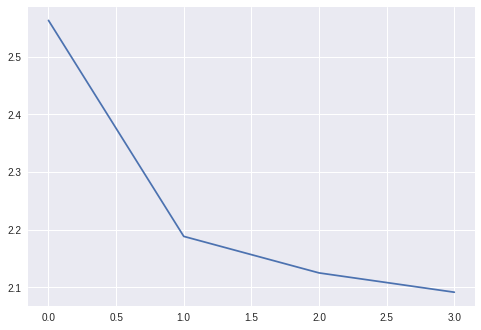

In [0]:
import matplotlib.pyplot as plt

plt.plot(losses_djokes)

# Sampling from the model


The model may not have learned how to form valid utf-8 sequences (eg for emojis) so we offer an optional argument that sets all non-ASCII bytes to 0 probability.

In [0]:
def sample(model, start_token='', max_iters=100, temperature=1.0, no_unicode=False):
  model = model.to('cpu')
  enc = CharByteEncoder()
  input_seq = enc.encode(start_token).tolist()[:-1] # Drop the end token
  
  hidden_prev = None
 
  for t in range(max_iters):
    x_t = torch.LongTensor([input_seq[t]]).unsqueeze(0)  # (b_sz=1, seq_len=1)
    y_t, hidden_t = model(x_t, hidden_prev)
    probs_t = F.softmax(y_t.squeeze() / temperature, dim=0)
    
    if no_unicode:
      mask = torch.cat([torch.ones(128), torch.zeros(128), torch.ones(3)])
      probs_t = probs_t * mask

    x_next = torch.multinomial(probs_t, 1)  # Randomly picks, based on probabilities

    input_seq.append(int(x_next))
    if int(x_next) == enc.end_idx:
      return enc.decode(torch.LongTensor(input_seq))
    hidden_prev = hidden_t
    
  return enc.decode(torch.LongTensor(input_seq + [enc.end_idx]))
  

In [0]:
sample(model, no_unicode=True)

'<s>Ktlits I rudiotch nonnine and Recan.</s>'

In [0]:
sample(model, no_unicode=True)

'<s>My elarise* the shagt/  y houver...Amwacktla tactunl.</s>'

In [0]:
sample(model, no_unicode=True, start_token='h')

'<s>hIaMcoru vAeH<pad>TNo3e0a </s>'